In [1]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
# Функции для генерации случайных состояний

# генерирует чистое состояние
def gen_psi(d, k):
    c = 2*(np.random.randn(d*k)-0.5) + 2j*(np.random.randn(d*k)-0.5)
    c = c/((abs(c)**2).sum()**0.5)
    return c

# фиделити
def F(r, s):
    return np.trace(la.sqrtm(la.sqrtm(r)@s@la.sqrtm(r))) ** 2

# 1. Случайные ошибки как квантовый процеcс

In [3]:
def U(e):
    return np.diag([1, 1, np.exp(1j*e*np.pi/8), np.exp(1j*e*np.pi/4)])

In [4]:
psi = gen_psi(4, 1)
psi_zero = np.zeros(4)
psi_zero[0] = 1

In [5]:
# Создадим функцию для численного эксперимента с выборкой из n реализаций оператора U
# Способ генерации e выбирается с помощью функции e_gen
def experiment(psi, e_gen, n=1000):
    k = 0
    es = e_gen(n)
    for e in es:
        phi = U(e) @ psi
        p = abs(psi_zero @ psi)**2
        k += np.random.binomial(1, p)
    P = k/n
    return P

In [6]:
# Получим следующее значение вероятности в одиночном эксперименте
print(experiment(psi, lambda x: np.random.normal(-0.1, 0.4, x)))

0.31


In [7]:
# Повторим эксперимент N раз
N = 10000
Ps = np.zeros(N)
for i in range(N):
    Ps[i] = experiment(psi, lambda x: np.random.normal(-0.1, 0.4, x))

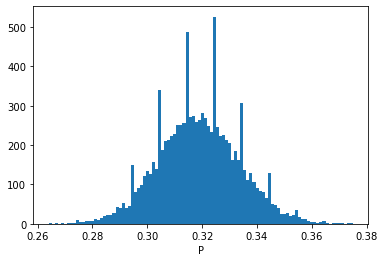

In [8]:
# Изобразим распределение на гистограмме
plt.hist(Ps, bins=100)
plt.xlabel('P')
plt.show()

In [9]:
# Повторим N раз эксперимент при нулевой ошибке
Ps_0 = np.zeros(N)
for i in range(N):
    Ps_0[i] = experiment(psi, lambda x: np.zeros(x))

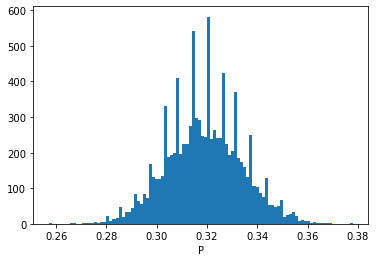

In [10]:
# Изобразим распределение на гистограмме
plt.hist(Ps_0, bins=100)
plt.xlabel('P')
plt.show()

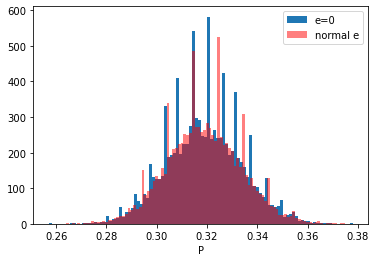

In [11]:
# Сравним распределения
plt.hist(Ps_0, bins=100, label='e=0')
plt.hist(Ps, bins=100, alpha=0.5, color='r', label='normal e')
plt.xlabel('P')
plt.legend()
plt.show()

In [12]:
# Создадим функцию плотности нашего распределения
def distr(x):
    mu = -0.1
    sigma = 0.4
    return 1/(2*np.pi)**0.5/sigma*np.exp(-(x-mu)**2/2/sigma**2)

# Создадим хи-матрицу из матрицы эволюции
def chi(x):
    U = np.diag([1, 1, np.exp(1j*x*np.pi/8), np.exp(1j*x*np.pi/4)])
    e = np.reshape(U, (1, 16), order='F')
    chi = np.outer(e,  np.conjugate(e))
    return chi

In [13]:
# Проинтегрируем хи-матрицу с функцией плотности распределения
chi_mean = np.zeros((16, 16), dtype=complex)
for i in range(16):
    for j in range(16):
        chi_mean[i, j] = quad(lambda x: distr(x)*chi(x)[i, j].real, -np.inf, np.inf)[0] +\
                      1j*quad(lambda x: distr(x)*chi(x)[i, j].imag, -np.inf, np.inf)[0]

In [14]:
# Выведем ненулевые элементы хи-матрциы
print(np.round(np.reshape(chi_mean[np.nonzero(chi_mean)], (4, 4)), 2))

[[1.  +0.j   1.  +0.j   0.99+0.04j 0.95+0.07j]
 [1.  +0.j   1.  +0.j   0.99+0.04j 0.95+0.07j]
 [0.99-0.04j 0.99-0.04j 1.  +0.j   0.99+0.04j]
 [0.95-0.07j 0.95-0.07j 0.99-0.04j 1.  +0.j  ]]


In [16]:
# Проведем спектральное разложение для нахождения матрицы e
d, u = la.eig(chi_mean)
e = u*d**0.5

In [17]:
# Из матрицы e вытащим операторы Крауса
E = np.zeros(16, dtype=object)
for i in range(16):
    E[i] = np.reshape(e[:, i], (4, 4), order='F')

In [18]:
# Найдем выходную матрицу плотности через операторы Краусса
rho = np.outer(psi, np.conjugate(psi))
rho_out = np.zeros_like(rho)
for e_i in E:
    rho_out += e_i @ rho @ np.conjugate(e_i).T
# Вычислим вероятность исхода |0>
P_mean = psi_zero @ rho_out @ psi_zero
print(P_mean)

(0.31901308853189714+5.421010862427522e-20j)


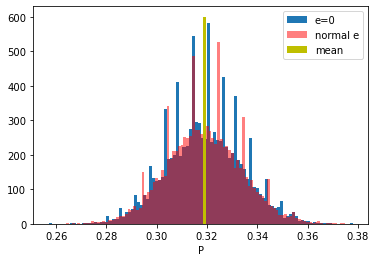

In [19]:
# Изобразим полученную вероятность вместе с гистограммами
# Видно, что она приходится на центр распределения
plt.hist(Ps_0, bins=100, label='e=0')
plt.hist(Ps, bins=100, alpha=0.5, color='r', label='normal e')
plt.bar(P_mean.real, 600, 0.001, color='y', label='mean')
plt.xlabel('P')
plt.legend()
plt.show()

# 2. Зашумлённые квантовые схемы

In [20]:
n = 5
dim = 2**n

In [21]:
# Создадим нужные гейты
I = np.eye(2)

H =1/2**0.5*np.array([[1,  1],
                      [1, -1]])

X = np.array([[0, 1],
              [1, 0]])

Toffoli = np.eye(8)
Toffoli[-2:, -2:] = X

CNOT = Toffoli[-4:, -4:]

SWAP = CNOT @ np.kron(H, H) @ CNOT @ np.kron(H, H) @ CNOT

# Создадим массив R_k для всех k
R = np.zeros(n+2, dtype=object)
for k in range(n+2):
    R[k] = np.array([[1, 0],
                     [0, np.exp(2j*np.pi/2**k)]])
    
R_conj = np.conjugate(R)

In [22]:
# Создадим controlled-R_k 
CR = np.zeros(n+1, dtype=object)
for k in range(n+1):
    CR[k] = CNOT @ np.kron(I, R_conj[k+1]) @ CNOT @ np.kron(R[k+1], R[k+1])

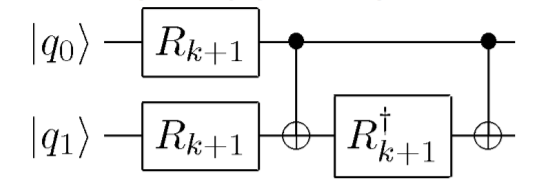

In [23]:
# 1-кубитное преобразование
def gate_1d(state, U1, k):
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask = 1 << n-1-k
    for ind in range(dim):
        for jk in range(2):
            b[ind] += state[ind - (ind&mask)+(jk << n-1-k)]*U1[int((ind & mask) != 0), jk]
    return b

# 2-кубитное преобразование
def gate_2d(state, U2, l, k):
    dim = state.shape[0]
    n = int(np.log2(dim))
    b = np.zeros(dim, dtype=complex)
    mask_k, mask_l = (1 << n-1-k) , (1 << n-1-l)
    mask = mask_k + mask_l
    for ind in range(dim):
        for jk in range(2):
            for jl in range(2):
                b[ind] += state[ind - (ind&mask)+(jk << n-1-k)+(jl << n-1-l)]*U2[int((ind & mask_k) != 0) +\
                                                                        (int((ind & mask_l) != 0) << 1), jk+(jl<<1)]
    return b

In [24]:
# Создадим квантовое преобразование Фурье с ошибкой после Адамара
def QFT(state, U, gamma=0):
    for i in range(n):
        err = np.random.uniform(-gamma, gamma, 1)[0]
        state = gate_1d(state, H, i)
        state = gate_1d(state, U(err), i)
        for k in range(2, n+1-i):
            state = gate_2d(state, CR[k], i+k-1, i)
    for i in range(int(n/2)):
        state = gate_2d(state, SWAP, i, n-1-i)
    return state


In [25]:
# Создадим оператор ошибки
def Uerr(e):
    delta = -e*np.pi/4
    theta =  np.pi/4-e*np.pi/8
    phi = np.pi/2
    return np.array([[np.cos(delta/2)-1j*np.cos(theta)*np.sin(delta/2), -1j*np.sin(theta)*np.sin(delta/2)*np.exp(-1j*phi)],
                     [-1j*np.sin(theta)*np.sin(delta/2)*np.exp(1j*phi), np.cos(delta/2)+1j*np.cos(theta)*np.sin(delta/2)]])

def no_err(e):
    return I

In [26]:
# Сгенерируем чистое состояние
psi_ = gen_psi(dim, 1)

In [27]:
# Посчитаем фиделити между ошибочным результатом Фурье и правильным для выборки ошибок
K = 1000
Fs = np.zeros((8, K))
gamma = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

phi0_ = QFT(psi_, no_err)

for i in range(8):
    for j in range(K):
        phi_ = QFT(psi_, Uerr, gamma[i])
        Fs[i, j] = abs(np.conjugate(phi0_) @ phi_)**2
        
# Усредним результаты по выборке и найдем доверительный интервал
Fs_mean = np.mean(Fs, axis=1)
Fs_high_q = np.quantile(Fs, 0.75, axis=1)
Fs_low_q = np.quantile(Fs, 0.25, axis=1)

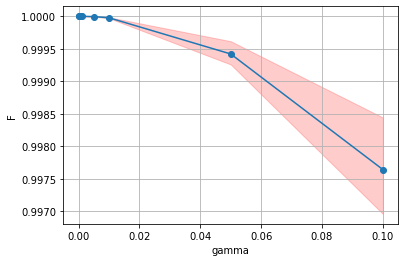

In [28]:
# Изобразим зависимость фиделити от уровня ошибки
plt.plot(gamma, Fs_mean, 'o-')
plt.fill_between(gamma, Fs_low_q, Fs_high_q, color='r', alpha=0.2)
plt.xlabel('gamma')
plt.ylabel('F')
plt.grid()
plt.show()